Chỉ số | Ý nghĩa | Khi nào dùng | Ghi chú
---|---|---|---
Silhouette Score | Đánh giá độ "gọn cụm" và "xa cụm khác" | Luôn dùng | Cao hơn thì tốt
Davies-Bouldin Index (DBI) | Đánh giá độ "chồng lấn" giữa các cụm | Khi muốn kiểm tra tính phân cách | Thấp hơn thì tốt
Calinski-Harabasz Index (CHI) | Tỉ lệ giữa độ phân tán giữa cụm và trong cụm | Khi muốn tối ưu về hiệu quả phân tách | Cao hơn thì tốt
Number of Clusters | Số lượng cụm được tạo ra | Luôn theo dõi |

# Khai báo thư viện

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d import Axes3D
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from joblib import Parallel, delayed
import time
# ------------------------------------------------------------------
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# ------------------------------------------------------------------
from scipy.stats import uniform
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# ------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
# ------------------------------------------------------------------
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score
from sklearn.metrics import make_scorer, silhouette_samples

# Data

In [22]:
df = pd.read_csv("D:\_Dev\_Group Project\Affinity-Propagation-ML-UEH\Data\Shopping Mall Customer Segmentation Data (Base)\data_preprocessed.csv")

In [23]:
df.head()

,Unnamed: 0,customer_id,age,annual_income,spending_score,gender_Female
0,0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,-1.145516,0.798813,1.337059,0.0
1,1,1770b26f-493f-46b6-837f-4237fb5a314e,0.180335,1.442076,1.545929,1.0
2,2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,0.369742,-0.743208,0.884507,1.0
3,3,9795712a-ad19-47bf-8886-4f997d6046e3,-1.476979,-1.038953,0.223086,0.0
4,4,64139426-2226-4cd6-bf09-91bce4b4db5e,-1.429627,0.842317,0.884507,0.0


In [24]:
data = df.drop(columns=["customer_id",],axis=1,)

In [25]:
X = data.copy()
X.head()

,Unnamed: 0,age,annual_income,spending_score,gender_Female
0,0,-1.145516,0.798813,1.337059,0.0
1,1,0.180335,1.442076,1.545929,1.0
2,2,0.369742,-0.743208,0.884507,1.0
3,3,-1.476979,-1.038953,0.223086,0.0
4,4,-1.429627,0.842317,0.884507,0.0


# Áp Dụng

## AP

### 1. Tham số thuật toán

```
preference
damping
```
=> Tập trung tối ưu vào damping và preference

In [36]:
ap = AffinityPropagation(random_state=42, damping=0.7, preference=-500.000)
ap.fit(X)

AffinityPropagation(damping=0.7, preference=-500.0, random_state=42)

### 2. Biểu diễn phân cụm

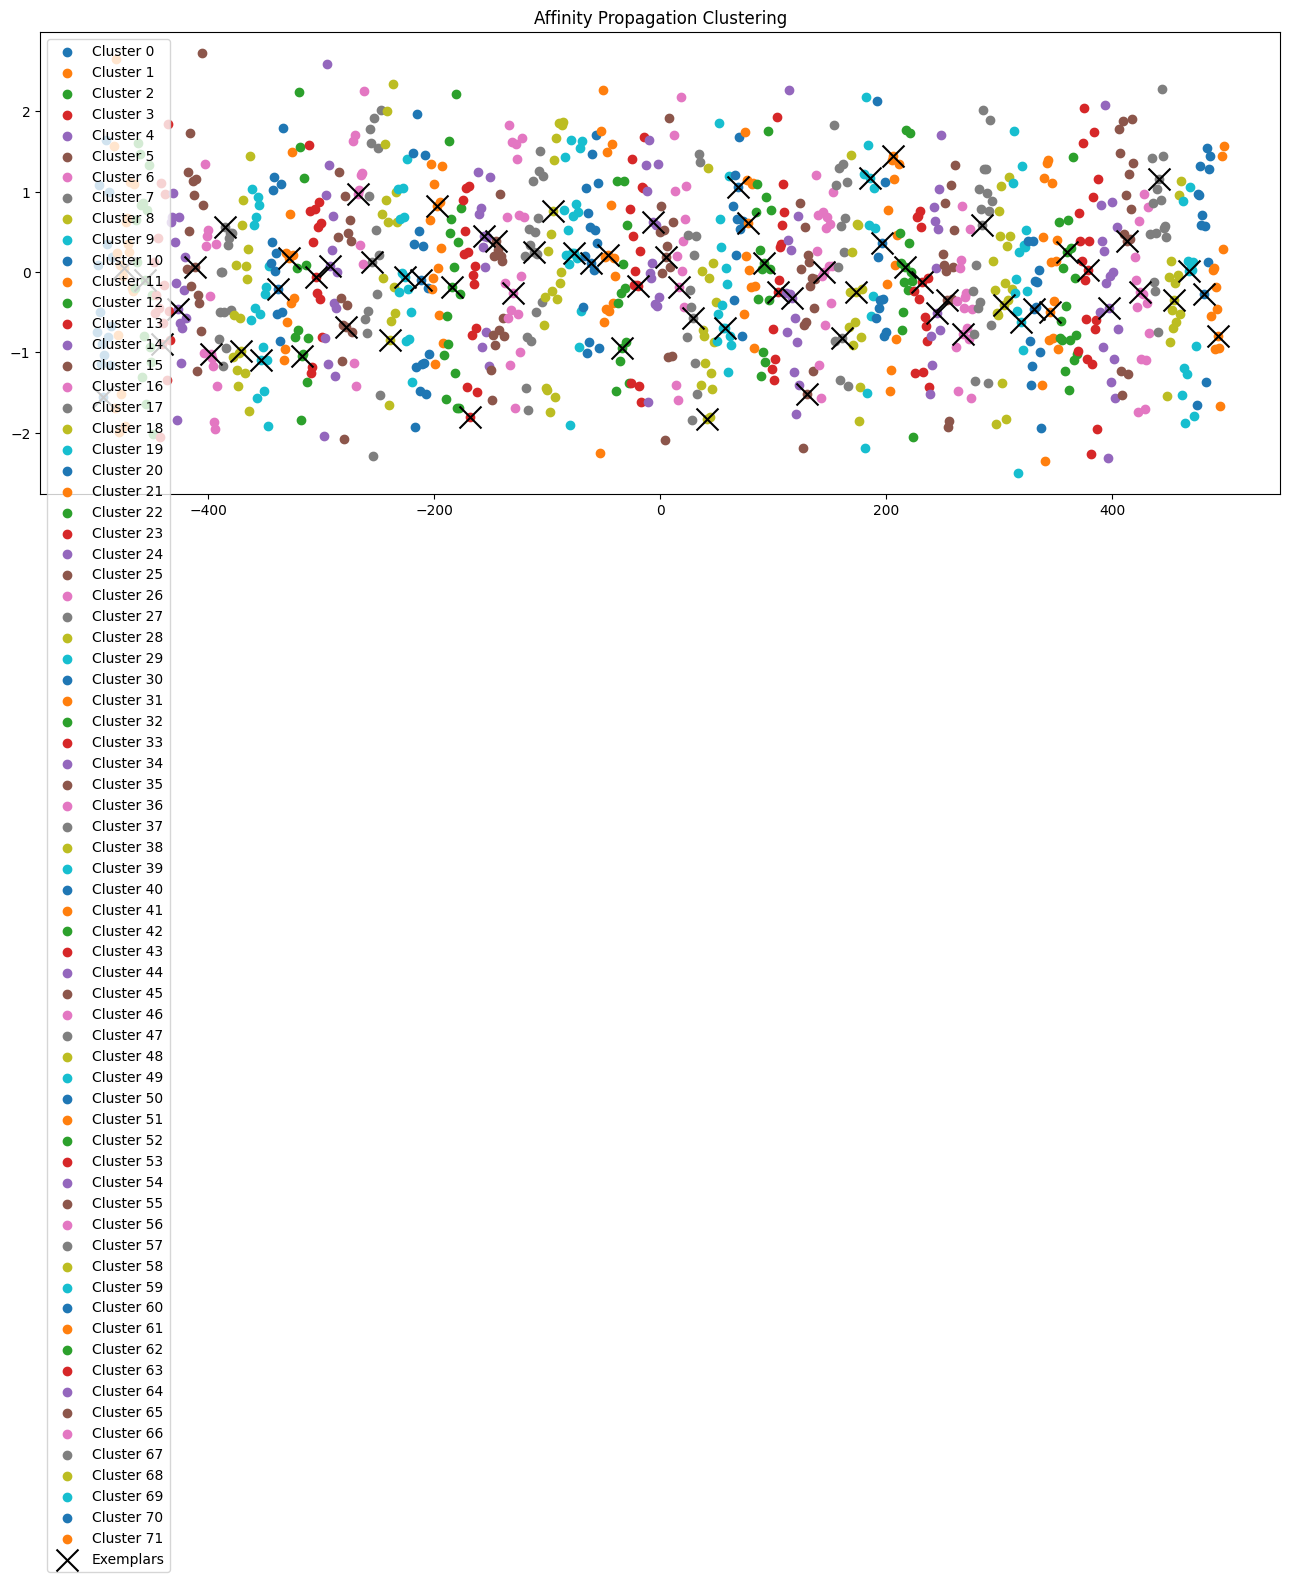

In [37]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

labels = ap.labels_
exemplars = ap.cluster_centers_indices_

plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("Affinity Propagation Clustering")
plt.show()

# Hyperparameter Optimization

### 1. Grid Search

In [28]:
# Grid Search Space
param_grid = {
    "damping": np.linspace(0.5, 0.9, 5),
    "preference": np.linspace(-500, 0, 100),
}
grid = ParameterGrid(param_grid)

# Khởi tạo biến lưu trữ kết quả tốt nhất
best_score = -1
best_params = None
best_model = None
best_labels = None
best_n_clusters = None

# Thực hiện Grid Search
for params in grid:
    model = AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=42
    )
    labels = model.fit_predict(X)

    n_clusters = len(set(labels))
    if n_clusters <= 1 or n_clusters >= len(X):
        continue  # Bỏ qua các trường hợp không hợp lệ

    score = silhouette_score(X, labels)

    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
        best_labels = labels
        best_n_clusters = n_clusters

# Tính các chỉ số đánh giá
silhouette_ap = silhouette_score(X, best_labels)
davies_bouldin_ap = davies_bouldin_score(X, best_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, best_labels)

In [29]:
print("[Grid Search] Affinity Propagation:")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldin Score: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabasz Score: {calinski_harabasz_ap:.3f}")
print(f"- Tham số tối ưu:")
print(f"\t+ Damping: {best_params['damping']:.3f}")
print(f"\t+ Preference: {best_params['preference']:.3f}")

[Grid Search] Affinity Propagation:
- Số lượng cụm: 72
- Silhouette Score: 0.432
- Davies Bouldin Score: 0.581
- Calinski Harabasz Score: 54108.842
- Tham số tối ưu:
	+ Damping: 0.700
	+ Preference: -500.000


### 2. Hyperopt

In [30]:
# Xây dựng không gian tìm kiếm
space = {
    "damping": hp.uniform("damping", 0.5, 0.9),
    "preference": hp.uniform("preference", -300, 0),
}


# Hàm mục tiêu cần tối ưu
def objective(params):
    model = AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=42
    )
    labels = model.fit_predict(X)

    n_clusters = len(set(labels))
    if n_clusters <= 1 or n_clusters >= len(X):
        return {"loss": 1, "status": STATUS_OK}  # Loss cao nếu cụm không hợp lệ

    score = silhouette_score(X, labels)
    return {
        "loss": -score,
        "status": STATUS_OK,
        "params": params,
        "n_clusters": n_clusters,
    }


# Thực hiện tối ưu
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Thực hiện mô hình với tham số tốt nhất
best_model = AffinityPropagation(
    damping=best["damping"], preference=best["preference"], random_state=42
)
best_labels = best_model.fit_predict(X)
best_n_clusters = len(set(best_labels))

# Tính các chỉ số
silhouette_ap = silhouette_score(X, best_labels)
davies_bouldin_ap = davies_bouldin_score(X, best_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, best_labels)

100%|██████████| 100/100 [00:42<00:00,  2.38trial/s, best loss: -0.4099386233756937]


In [31]:
print("[Hyperopt] Affinity Propagation:")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldin Score: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabasz Score: {calinski_harabasz_ap:.3f}")
print(f"- Tham số tối ưu:")
print(f"\t+ Damping: {best['damping']:.3f}")
print(f"\t+ Preference: {best['preference']:.3f}")

[Hyperopt] Affinity Propagation:
- Số lượng cụm: 88
- Silhouette Score: 0.410
- Davies Bouldin Score: 0.611
- Calinski Harabasz Score: 61114.678
- Tham số tối ưu:
	+ Damping: 0.567
	+ Preference: -299.287


### 3. Optuna

|Tính năng | Ý nghĩa |
|---|---|
|Sơ đồ dòng tối ưu hóa | Hiểu tổng quan quá trình|
|Early Stopping (Pruning) | Tiết kiệm thời gian|
|Visualization | Nhìn thấy quá trình tối ưu trực quan|

In [32]:
import optuna
from optuna.pruners import MedianPruner

# Hàm objective với pruning
def objective(trial):
    damping = trial.suggest_float('damping', 0.5, 0.9)
    preference = trial.suggest_float('preference', -300, 0)
    
    model = AffinityPropagation(
        damping=damping,
        preference=preference,
        random_state=42
    )
    labels = model.fit_predict(X)
    
    n_clusters = len(set(labels))
    if n_clusters <= 1 or n_clusters >= len(X):
        return 1.0  # Trả về loss cao ngay

    score = silhouette_score(X, labels)

    # Gửi signal cho Optuna pruning
    trial.report(-score, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return -score  # Vì Optuna minimize

# Tạo Study có pruner
pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=0)
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100)

# Sau khi tìm xong, build lại mô hình tốt nhất
best = study.best_params

best_model = AffinityPropagation(
    damping=best['damping'],
    preference=best['preference'],
    random_state=42
)
best_labels = best_model.fit_predict(X)
best_n_clusters = len(set(best_labels))

# Tính các chỉ số đánh giá
silhouette_ap = silhouette_score(X, best_labels)
davies_bouldin_ap = davies_bouldin_score(X, best_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, best_labels)


[I 2025-05-06 20:00:38,346] A new study created in memory with name: no-name-ee161c25-6b9a-4db2-859b-309083a66228
[I 2025-05-06 20:00:38,798] Trial 0 finished with value: -0.39122384114065717 and parameters: {'damping': 0.8041527997877598, 'preference': -177.88515385985852}. Best is trial 0 with value: -0.39122384114065717.
[I 2025-05-06 20:00:39,575] Trial 1 finished with value: -0.39753680126269286 and parameters: {'damping': 0.8890141570796, 'preference': -234.5872386465536}. Best is trial 1 with value: -0.39753680126269286.
[I 2025-05-06 20:00:40,234] Trial 2 finished with value: -0.3244471251487356 and parameters: {'damping': 0.7066689150420864, 'preference': -45.779940923988136}. Best is trial 1 with value: -0.39753680126269286.
[I 2025-05-06 20:00:40,553] Trial 3 finished with value: -0.38363396565384805 and parameters: {'damping': 0.5227232019531549, 'preference': -160.36800142357512}. Best is trial 1 with value: -0.39753680126269286.
[I 2025-05-06 20:00:40,917] Trial 4 finishe

In [33]:
print("[Optuna] Affinity Propagation:")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldin Score: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabasz Score: {calinski_harabasz_ap:.3f}")
print(f"- Tham số tối ưu:")
print(f"\t+ Damping: {best['damping']:.3f}")
print(f"\t+ Preference: {best['preference']:.3f}")

[Optuna] Affinity Propagation:
- Số lượng cụm: 88
- Silhouette Score: 0.410
- Davies Bouldin Score: 0.610
- Calinski Harabasz Score: 61311.592
- Tham số tối ưu:
	+ Damping: 0.656
	+ Preference: -299.854


In [34]:
# Vẽ lịch sử tối ưu (Optimization History)
optuna.visualization.plot_optimization_history(study).show()

In [35]:
# Vẽ tầm quan trọng các tham số (Hyperparameter Importance)
optuna.visualization.plot_param_importances(study).show()

# Một số kết luận

## 1. Hyperopt/Optuna

Công cụ | Ưu điểm
---|---
Hyperopt | Dễ code, nhanh, tối ưu tốt với bài toán đơn giản
Optuna | Giao diện đẹp, logging mạnh, hỗ trợ visualization trực quan

## 2. Lựa chọn kỹ thuật

Tiêu chí | Grid Search | Hyperopt / Optuna
---|---|---
Cách tìm kiếm | Quét toàn bộ (mọi tổ hợp parameter có thể) | Tối ưu hóa thông minh dựa trên mẫu ngẫu nhiên + học từ kết quả trước
Phủ không gian tham số | Đảm bảo mọi vùng đều được quét qua | Không đảm bảo quét hết — ưu tiên vùng thấy "ngon" sớm
Phụ thuộc random | Không | Có
Độ tin cậy khi mẫu nhỏ | Cao (vì bao phủ đều) | Thấp (dễ mắc kẹt vào vùng xấu)

<p>

Grid Search | Hyperopt / Optuna
---|---
Tin cậy hơn khi số lượng trial nhỏ | Cần nhiều trial mới hiệu quả
Tìm chắc chắn preference tốt | Dễ tìm nhầm preference xấu
Độ ổn định cao | Độ dao động lớn

**Vì vậy**:
- Grid Search: Khi ít mẫu và không gian nhỏ, nó rất hiệu quả vì đi hết từng ngóc ngách.
- Hyperopt / Optuna: Cần nhiều lượt thử mới "học" được vùng tốt vì khi ít trial thì hay bị chọn nhầm vùng xấu.